In [1]:
import re
import sys
import pandas as pd
sys.path.append('/home/oliver/dev/uzh/atai_bot/bot')
from util.question_analyser import QuestionAnalyser
import pickle

In [2]:
mul=[           "Show me a picture of Halle Berry. ",
            "What does Julia Roberts look like? ",
    "Let me know what Sandra Bullock looks like. ", ]

In [3]:
# Sample sentences
sentences = [
    # Image requests
    "Show me a picture of James Bond",
    "Display the poster of Jurassic Park",
    # Text requests
    "Is Public Enemy No. 1 - Todestrieb a crime thriller?",
    "Did Christopher Nolan direct Inception?"
]

# Keywords indicating an image request
image_keywords = [
    "picture of", "display the", "look like", "photo of", "movie poster",
    "cover of", "trailer of", "image of", "cast of", "scene from"
]

def is_image_request(sentence):
    for keyword in image_keywords:
        if re.search(keyword, sentence, re.IGNORECASE):
            return True
    return False

# Classify each sentence
for sentence in sentences:
    if is_image_request(sentence):
        print(f"Image request: {sentence}")
    else:
        print(f"Text response: {sentence}")


Image request: Show me a picture of James Bond
Image request: Display the poster of Jurassic Park
Text response: Is Public Enemy No. 1 - Todestrieb a crime thriller?
Text response: Did Christopher Nolan direct Inception?


In [4]:
analyser=QuestionAnalyser()

Some weights of the model checkpoint at dslim/bert-large-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [5]:
with open("human_dict.pickle", 'rb') as f:
    human_dict = pickle.load(f)
names = list(human_dict.keys())
with open("/home/oliver/dev/uzh/atai_bot/dataset/updated_dataset.pickle", 'rb') as f:
    graph = pickle.load(f)

file_path = '/home/oliver/dev/uzh/atai_bot/dataset/movienet/images.json'

df = pd.read_json(file_path)
df['cast'] = df['cast'].astype(str)
df['type'] = df['type'].astype(str)

In [6]:
movies, name = analyser.get_movie_title("How does Richard Marquand look like?")
entity = human_dict[name]
print(human_dict[name])

_____________________
People: ['Richard Marquand']
Movies: []
FUZZYWUZZY results: ("the rich man's wife", 55.55555555555556, 6893)
FUZZYWUZZY results: ('jan dara', 0.0, 0)
FUZZYWUZZY results: ('richard marquand', 100.0, 84048)
http://www.wikidata.org/entity/Q471402


In [7]:
query_template = """PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>
PREFIX ddis: <http://ddis.ch/atai/>
SELECT ?value
WHERE {{
     {0} wdt:P345 ?value .
}}
"""

query = query_template.format("wd:"+entity.split('/')[-1])
print(query)

# Ensure to use the 'query' variable, not 'query_template' for execution
result = graph.query(query)
imdb_id = None
for row in result:
    imdb_id= str(row[0])


PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>
PREFIX ddis: <http://ddis.ch/atai/>
SELECT ?value
WHERE {
     wd:Q471402 wdt:P345 ?value .
}


In [8]:
df.head()

,w,movie,img,h,type,cast
0,1666,[tt4882376],0315/rm601699072.jpg,1000,behind_the_scenes,"['nm8801745', 'nm0001401']"
1,999,[tt2318625],2538/rm814292736.jpg,562,still_frame,['nm2072214']
2,1500,[tt4003966],0354/rm2068192512.jpg,1000,still_frame,['nm0268626']
3,1333,[],3777/rm27402752.jpg,1000,publicity,['nm6655379']
4,704,[],3459/rm537652736.jpg,1000,event,"['nm1577190', 'nm7097953']"


In [15]:
# Assuming filtered_df is already defined as you mentioned
filtered_df = df[df['cast'].str.contains(imdb_id) & df["type"].str.contains("event")]
if len(filtered_df)==0:
    filtered_df = df[df['cast'].str.contains(imdb_id) & df["type"].str.contains("publicity")]
# Sort filtered_df based on the string length of 'cast'
sorted_df = filtered_df.sort_values(by='cast', key=lambda col: col.str.len(), ascending=True)

sorted_df['img'].iloc[0]

'3681/rm1666919936.jpg'

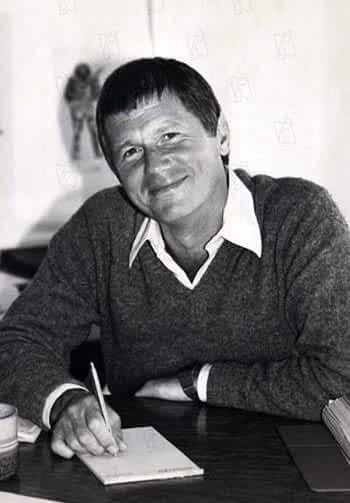

In [16]:
from IPython.display import Image

# Display an image by specifying the file path
Image(filename=f'/home/oliver/dev/uzh/atai_bot/dataset/movienet/images/{sorted_df["img"].iloc[0]}')

In [ ]:
df.to_pickle("movienet_index.pickle")